In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,calculate_shift_value,plot_xgb_feature_importance


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/美元指数拟合残差_10年期美国国债收益率.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['美元指数拟合残差/10年期美国国债收益率'].last_valid_index()

sheet.columns  

Index(['美元指数拟合残差/10年期美国国债收益率', '欧元区经济惊喜指数', 'COMEX黄金价格Non-Trend/F0.02',
       '德国-美国10年期国债收益率(预测/最新)', '美国ISM非制造业PMI', '欧元区-美国经济惊喜指数', '美国费城+纽约制造业活动',
       '美国经济惊喜指数', '10年期美国国债收益率', 'WTI连1合约价格（路透）', '标普500/德国DAX指数',
       '日经225指数（同花顺）', 'CFTC 美元指数投机头寸'],
      dtype='object')

In [4]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/Horizon-Insights/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/wti_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['wti原油期货价格'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()

,Date,WTI原油期货价格预测
19,2025-11-03,72.70
18,2025-11-04,76.47
17,2025-11-05,76.77
16,2025-11-06,75.41
15,2025-11-07,75.69


In [5]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', 'WTI原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['WTI连1合约价格（路透）'] = sheet_daily['WTI连1合约价格（路透）'].fillna(sheet_daily['WTI原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['WTI原油期货价格预测'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [6]:
sheet1 = pd.read_excel('eta/10年期美国国债收益率_合并数据.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet1.set_index('Date', inplace=True) 
sheet1 = sheet1.reset_index().rename(columns={'index': 'Date'})
sheet1 = sheet1[['Date', '10年期美国国债收益率']].dropna(subset=['10年期美国国债收益率']).sort_values('Date')
sheet1.head()

,Date,10年期美国国债收益率
20,2025/11/03,4.23
19,2025/11/04,4.24
18,2025/11/05,4.25
17,2025/11/06,4.25
16,2025/11/07,4.30


In [7]:
# 将sheet1的日期转换为datetime格式
sheet1['Date'] = pd.to_datetime(sheet1['Date'])
sheet1 = sheet1.set_index('Date')
# 合并两个DataFrame的索引,保留sheet中已有的值
combined_index = sheet.index.union(sheet1.index)
sheet = sheet.reindex(combined_index)
# 用sheet1填充sheet中的空值
sheet.loc[sheet['10年期美国国债收益率'].isna(), '10年期美国国债收益率'] = sheet1['10年期美国国债收益率']

In [8]:
last_day

Timestamp('2025-10-31 00:00:00')

In [9]:
################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=55, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

In [10]:
sheet.columns

Index(['美元指数拟合残差/10年期美国国债收益率', '欧元区经济惊喜指数', 'COMEX黄金价格Non-Trend/F0.02',
       '德国-美国10年期国债收益率(预测/最新)', '美国ISM非制造业PMI', '欧元区-美国经济惊喜指数', '美国费城+纽约制造业活动',
       '美国经济惊喜指数', '10年期美国国债收益率', 'WTI连1合约价格（路透）', '标普500/德国DAX指数',
       '日经225指数（同花顺）', 'CFTC 美元指数投机头寸'],
      dtype='object')

In [11]:
################################# 处理缺失值 #################################
fill_methods = {
'欧元区经济惊喜指数':'interpolate', 
'COMEX黄金价格Non-Trend/F0.02':'interpolate',
'德国-美国10年期国债收益率(预测/最新)':'interpolate', 
'美国ISM非制造业PMI':'interpolate', 
'欧元区-美国经济惊喜指数':'interpolate',
'美国费城+纽约制造业活动':'interpolate', 
'美国经济惊喜指数':'interpolate', 
'10年期美国国债收益率':'interpolate',
'WTI连1合约价格（路透）':'interpolate',
'标普500/德国DAX指数':'interpolate',
'日经225指数（同花顺）':'interpolate',
'CFTC 美元指数投机头寸':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '美元指数拟合残差/10年期美国国债收益率'] = sheet.loc[:last_day, '美元指数拟合残差/10年期美国国债收益率'].interpolate(method='linear')

#################################  因子处理  #################################



shift_value = calculate_shift_value(sheet, '欧元区经济惊喜指数', -7.4,last_day_index=pd.Timestamp('2025-06-05'), default_shift=20)
sheet['欧元区经济惊喜指数_提前20天'] = sheet['欧元区经济惊喜指数'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '德国-美国10年期国债收益率(预测/最新)', -1.73,last_day_index=pd.Timestamp('2025-06-11'), default_shift=20)
sheet['德国-美国10年期国债收益率(预测/最新)_提前10天'] = sheet['德国-美国10年期国债收益率(预测/最新)'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '欧元区-美国经济惊喜指数', -7,last_day_index=pd.Timestamp('2025-07-10'), default_shift=56)
sheet['欧元区-美国经济惊喜指数_提前55天'] = sheet['欧元区-美国经济惊喜指数'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '美国ISM非制造业PMI', 50.8,last_day_index=pd.Timestamp('2025-05-30'), default_shift=40)
sheet['美国ISM非制造业PMI_提前40天'] = sheet['美国ISM非制造业PMI'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '美国经济惊喜指数', 0.8,last_day_index=pd.Timestamp('2025-06-30'), default_shift=45)
sheet['美国经济惊喜指数_提前45天'] = sheet['美国经济惊喜指数'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '美国费城+纽约制造业活动', -34.5,last_day_index=pd.Timestamp('2025-05-28'), default_shift=21)
sheet['美国费城+纽约制造业活动_提前20天'] = sheet['美国费城+纽约制造业活动'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '标普500/德国DAX指数', 0.2484,last_day_index=pd.Timestamp('2025-06-06'), default_shift=30)
sheet['标普500/德国DAX指数_提前30天'] = sheet['标普500/德国DAX指数'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '日经225指数（同花顺）', 35839.99,last_day_index=pd.Timestamp('2025-05-12'), default_shift=20)
sheet['日经225指数（同花顺）_提前10天'] = sheet['日经225指数（同花顺）'].shift(shift_value)


sheet['CFTC 美元指数投机头寸_提前88天'] = sheet['CFTC 美元指数投机头寸'].shift(88)
sheet['CFTC 美元指数投机头寸_提前88天_逆序'] = reverse_column(sheet, 'CFTC 美元指数投机头寸_提前88天')

sheet['欧元区经济惊喜指数_提前20天_逆序'] = reverse_column(sheet, '欧元区经济惊喜指数_提前20天')
sheet['德国-美国10年期国债收益率(预测/最新)_提前10天_逆序'] = reverse_column(sheet, '德国-美国10年期国债收益率(预测/最新)_提前10天')
sheet['欧元区-美国经济惊喜指数_提前55天_逆序'] = reverse_column(sheet, '欧元区-美国经济惊喜指数_提前55天')
'''
sheet['美国经济惊喜指数_提前45天_2023-04-01'] = np.where(
    sheet.index >= pd.Timestamp('2023-04-01'),
    sheet['美国经济惊喜指数_提前45天'],
    np.nan
)
sheet['COMEX黄金价格Non-Trend/F0.02_提前50天_2023-12-01'] = np.where(
    sheet.index >= pd.Timestamp('2023-12-01'),
    sheet['COMEX黄金价格Non-Trend/F0.02_提前50天'],
    np.nan
)
'''
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-11-10')]
# 获取当前日期并计算未来20个工作日
from pandas.tseries.offsets import BDay
current_date = pd.Timestamp.now()
future_date = current_date + BDay(20)
sheet_daily = sheet_daily[sheet_daily['Date'] <= future_date]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['美元指数拟合残差/10年期美国国债收益率'].notna())
]

################################# 数据 读取-处理 结束 #################################

在2025年4月没有找到欧元区经济惊喜指数为-7.4的记录
在2025年4月没有找到德国-美国10年期国债收益率(预测/最新)为-1.73的记录
在2025年4月没有找到欧元区-美国经济惊喜指数为-7的记录
在2025年4月没有找到美国ISM非制造业PMI为50.8的记录
在2025年4月没有找到美国经济惊喜指数为0.8的记录
在2025年4月没有找到美国费城+纽约制造业活动为-34.5的记录
在2025年4月没有找到标普500/德国DAX指数为0.2484的记录
在2025年4月没有找到日经225指数（同花顺）为35839.99的记录


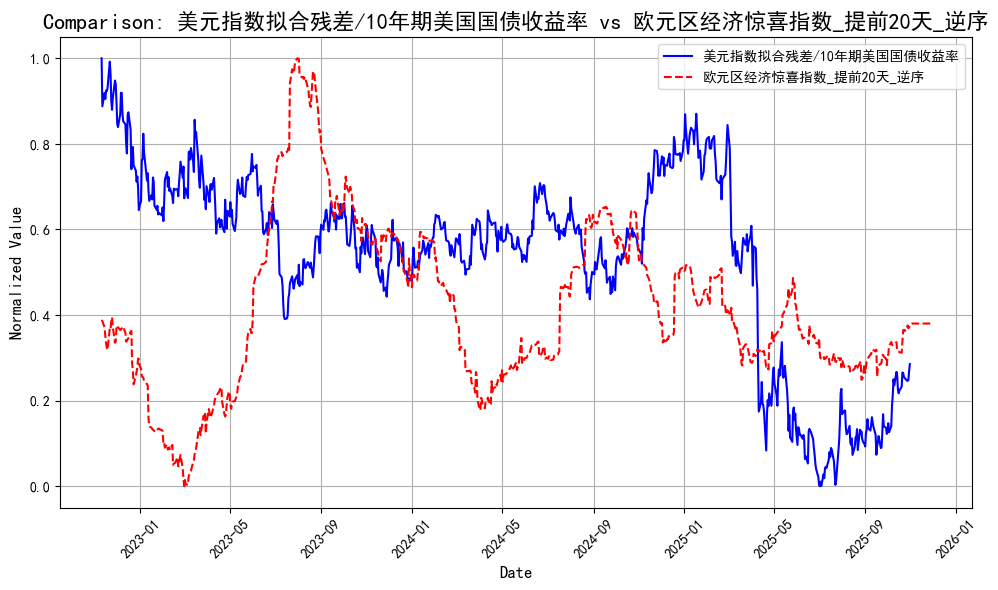

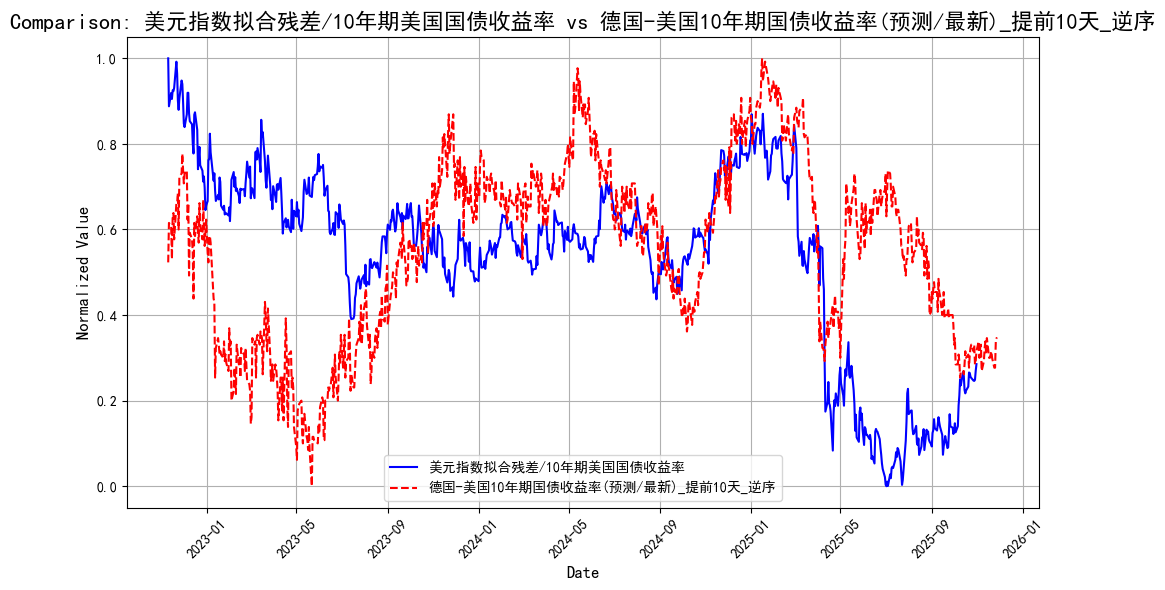

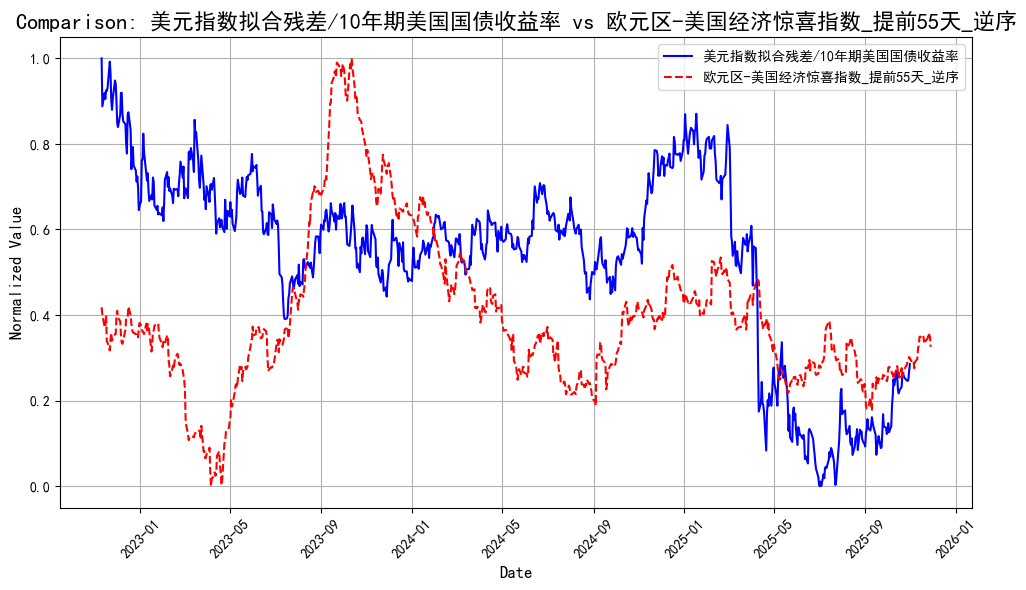

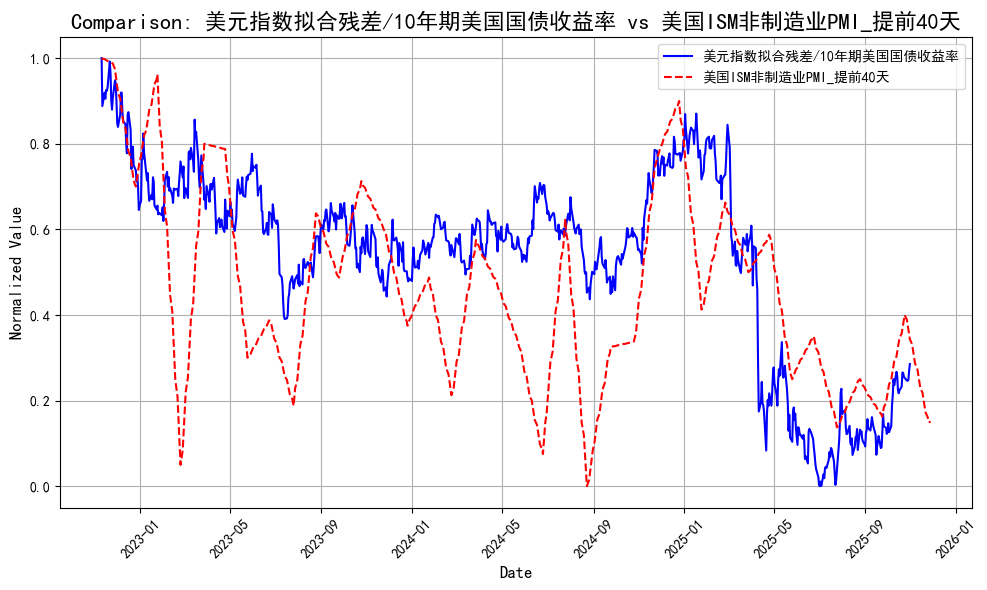

列 'COMEX黄金价格Non-Trend/F0.02_提前50天' 不存在于 DataFrame 中。


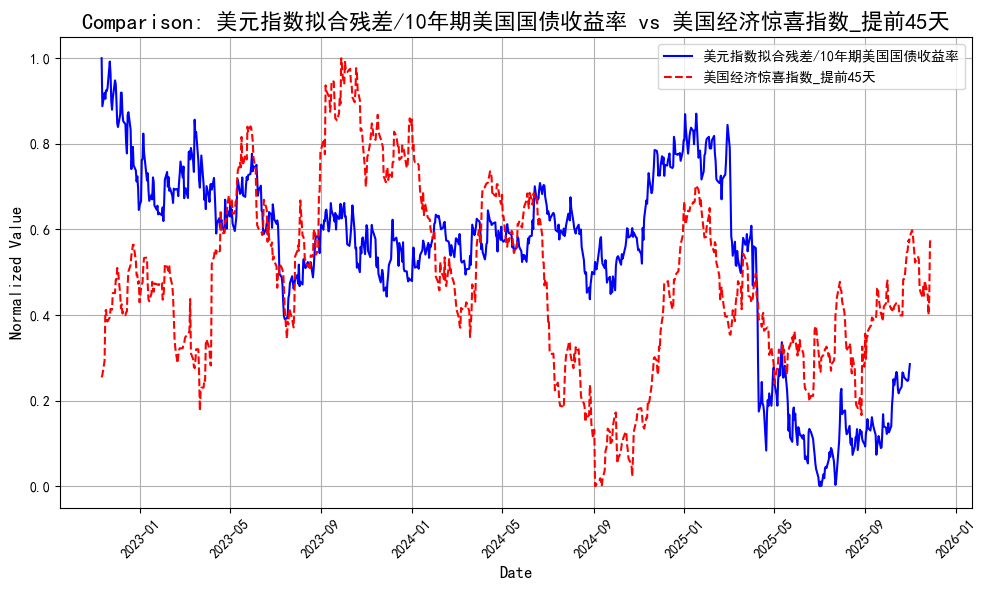

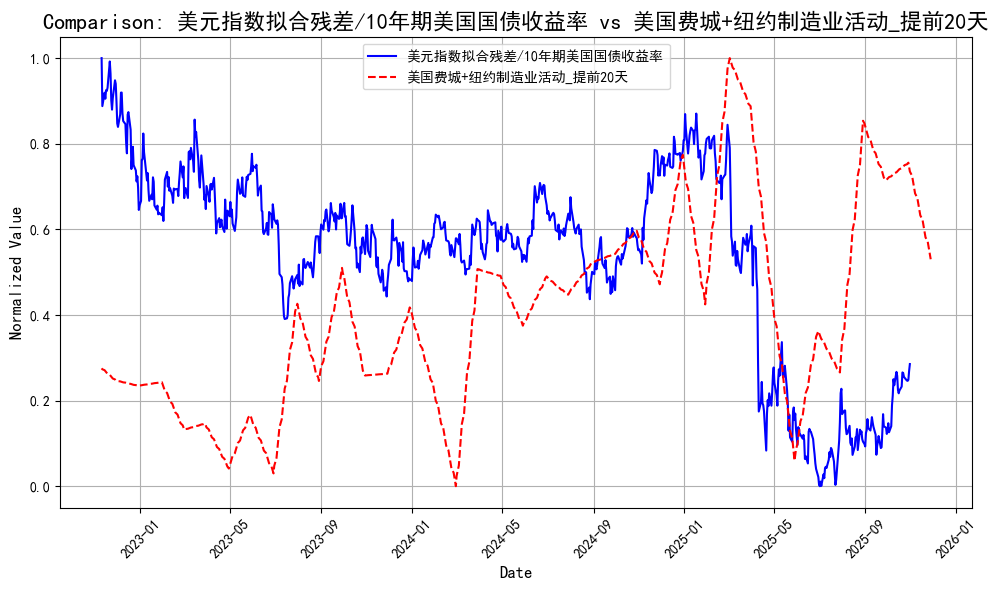

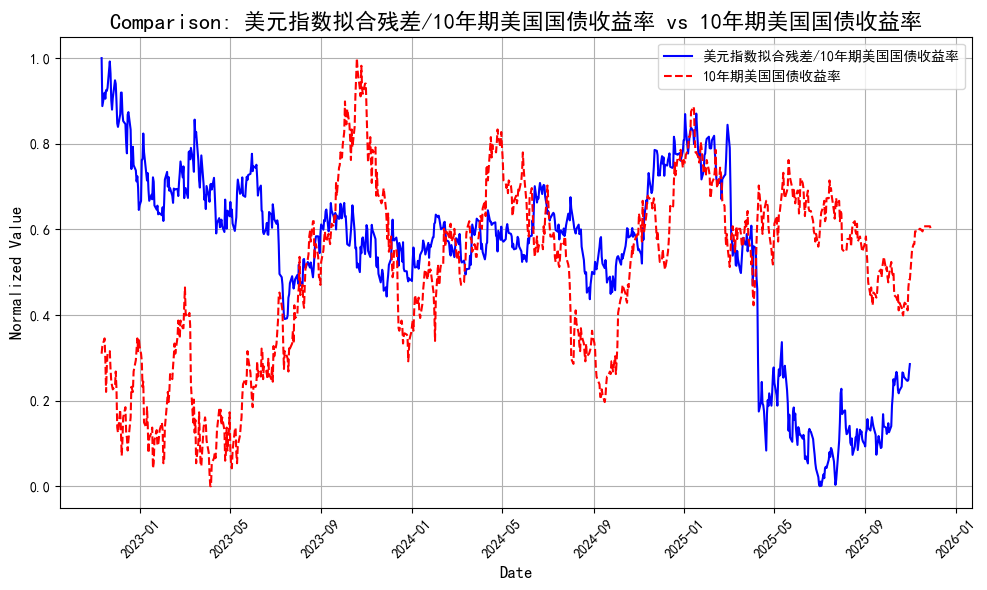

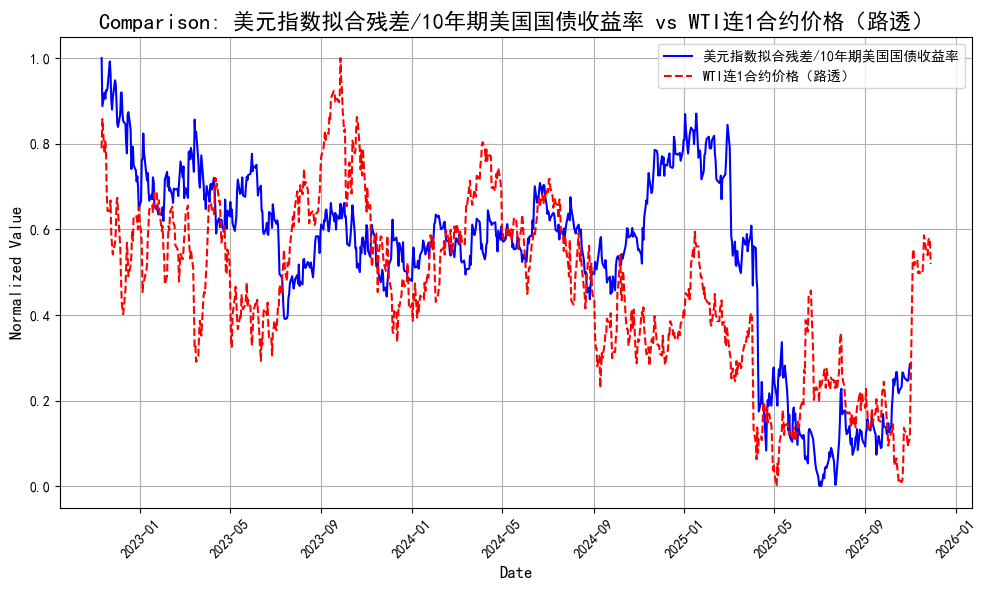

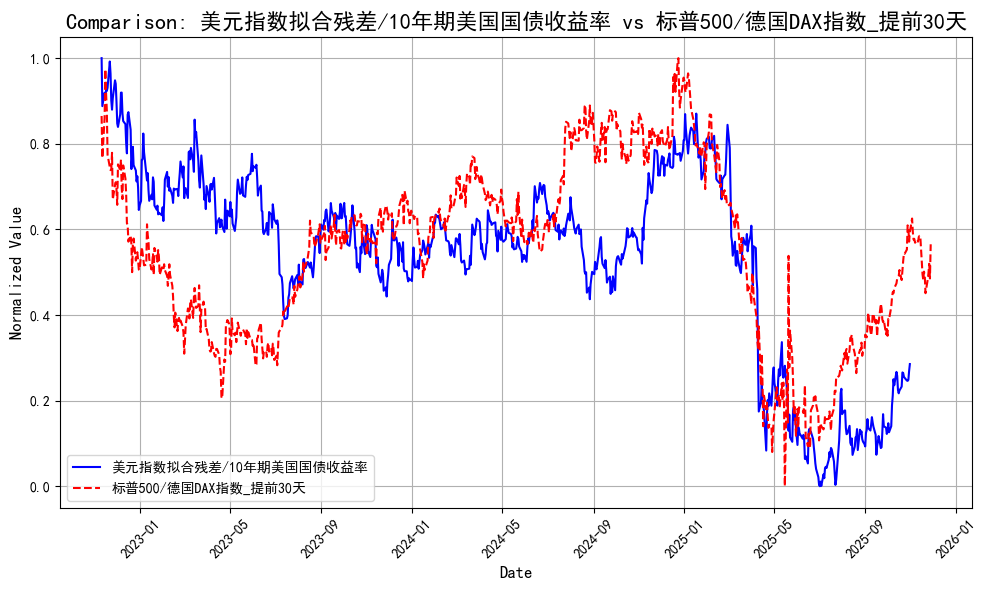

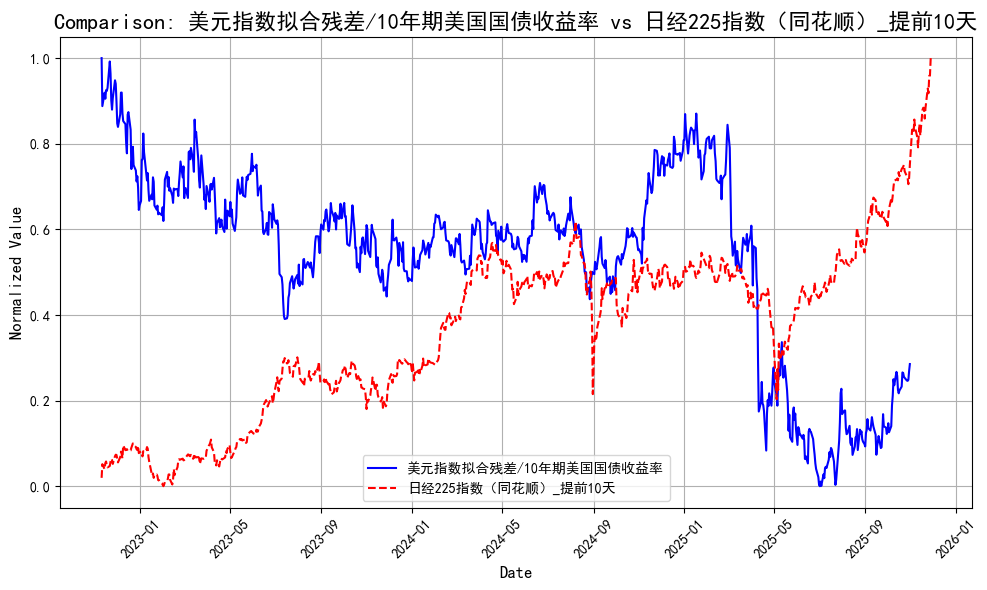

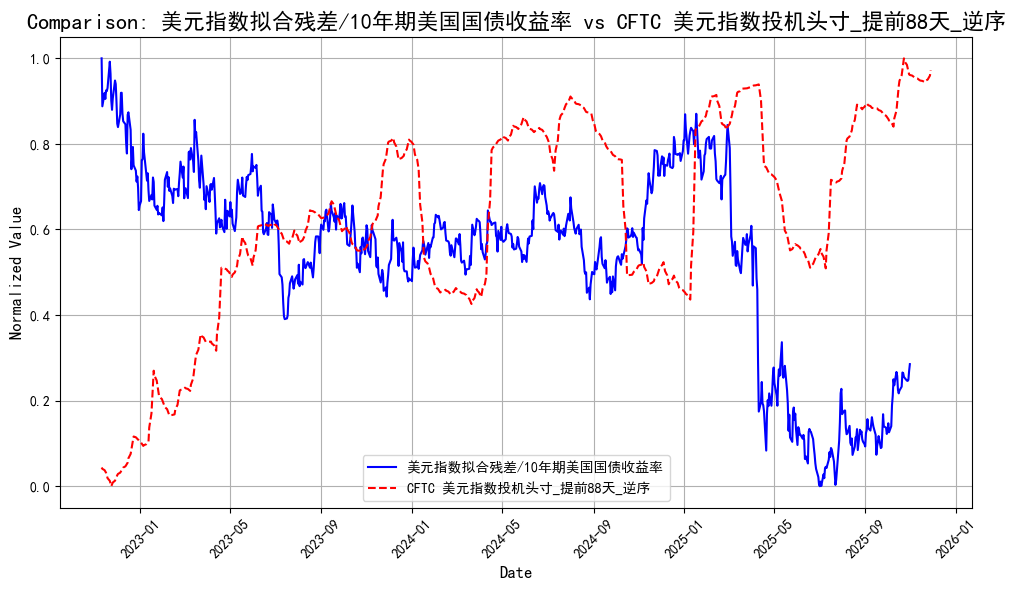

In [12]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='美元指数拟合残差/10年期美国国债收益率', 
    compare_cols=[
        '欧元区经济惊喜指数_提前20天_逆序',
        '德国-美国10年期国债收益率(预测/最新)_提前10天_逆序',
        '欧元区-美国经济惊喜指数_提前55天_逆序',
        '美国ISM非制造业PMI_提前40天',
        'COMEX黄金价格Non-Trend/F0.02_提前50天',
        '美国经济惊喜指数_提前45天',
        '美国费城+纽约制造业活动_提前20天',
        '10年期美国国债收益率',
        'WTI连1合约价格（路透）',
        '标普500/德国DAX指数_提前30天',
        '日经225指数（同花顺）_提前10天',
        'CFTC 美元指数投机头寸_提前88天_逆序'
       ]
)

In [13]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 2
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '欧元区经济惊喜指数_提前20天_逆序',
#        '德国-美国10年期国债收益率(预测/最新)_提前10天_逆序',
        '欧元区-美国经济惊喜指数_提前55天_逆序',
        '美国ISM非制造业PMI_提前40天',
        '美国经济惊喜指数_提前45天',
        '美国费城+纽约制造业活动_提前20天',
        '10年期美国国债收益率',
        'WTI连1合约价格（路透）',
        '标普500/德国DAX指数_提前30天',
#        '日经225指数（同花顺）_提前10天',
        'CFTC 美元指数投机头寸_提前88天_逆序'
]

predict_column = '美元指数拟合残差/10年期美国国债收益率'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 95)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 3.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'booster': 'gblinear',  # 使用线性模型
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.1,  # 学习率
    'reg_alpha': 0.5,  # L1正则化
    'reg_lambda': 0.9,  # L2正则化
    'eval_metric': 'rmse',  # 评估指标：选择"rmse"
    'seed': 42  # 随机种子
}

num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=50,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:3.28333	train-rmse:2.68121


[221]	eval-rmse:2.32404	train-rmse:2.05590


训练集 MSE (DMatrix): 4.3036, 训练集 R² (DMatrix): 0.4621
测试集 MSE (DMatrix): 5.4012, 测试集 R² (DMatrix): -503.2057


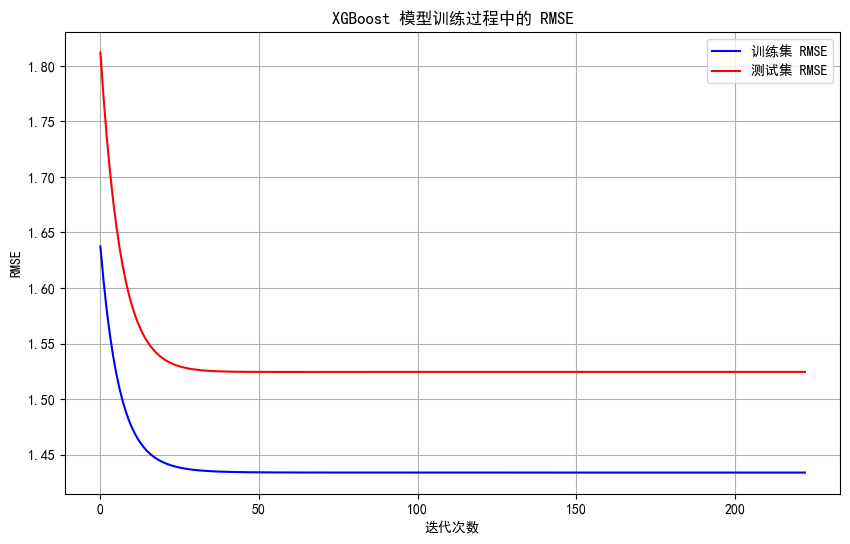

In [14]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:2.70399


[218]	train-rmse:2.06189


全部数据 MSE: 4.2514, 全部数据 R²: 0.4692


In [16]:
'''
################################# 可视化 #################################
# 创建一个新的图形
plt.figure(figsize=(30, 8))

# 训练集和测试集的连接点(预测值)
train_last_date = train_data['Date'].iloc[-1]
test_first_date = test_data['Date'].iloc[0]
train_last_value = y_train_pred_dmatrix[-1]
test_first_value = y_test_pred_dmatrix[0]

# 训练集和测试集的连接点(真实值)
train_last_date_real = train_data['Date'].iloc[-1]
test_first_date_real = test_data['Date'].iloc[0]
train_last_value_real = y_train.iloc[-1]
test_first_value_real = y_test.iloc[0]

# 测试集和未来集的连接点(普通预测)
test_last_date = test_data['Date'].iloc[-1]
future_first_date = future_data['Date'].iloc[0]
test_last_value = y_test_pred_dmatrix[-1]
future_first_value = future_data['预测值'].iloc[0]

# 测试集和未来集的连接点(全量预测)
test_last_date_all = test_data['Date'].iloc[-1]
future_first_date_all = future_data['Date'].iloc[0]
test_last_value_all = y_test.iloc[-1]
future_first_value_all = future_data['预测值_全量'].iloc[0]

# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加连接线
plt.plot([train_last_date, test_first_date], [train_last_value, test_first_value], color='purple')
plt.plot([test_last_date, future_first_date], [test_last_value, future_first_value], color='red')
plt.plot([train_last_date_real, test_first_date_real], [train_last_value_real, test_first_value_real], color='blue')
plt.plot([test_last_date_all, future_first_date_all], [test_last_value_all, future_first_value_all], color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('美元指数拟合残差/10年期美国国债收益率')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n################################# 可视化 #################################\n# 创建一个新的图形\nplt.figure(figsize=(30, 8))\n\n# 训练集和测试集的连接点(预测值)\ntrain_last_date = train_data['Date'].iloc[-1]\ntest_first_date = test_data['Date'].iloc[0]\ntrain_last_value = y_train_pred_dmatrix[-1]\ntest_first_value = y_test_pred_dmatrix[0]\n\n# 训练集和测试集的连接点(真实值)\ntrain_last_date_real = train_data['Date'].iloc[-1]\ntest_first_date_real = test_data['Date'].iloc[0]\ntrain_last_value_real = y_train.iloc[-1]\ntest_first_value_real = y_test.iloc[0]\n\n# 测试集和未来集的连接点(普通预测)\ntest_last_date = test_data['Date'].iloc[-1]\nfuture_first_date = future_data['Date'].iloc[0]\ntest_last_value = y_test_pred_dmatrix[-1]\nfuture_first_value = future_data['预测值'].iloc[0]\n\n# 测试集和未来集的连接点(全量预测)\ntest_last_date_all = test_data['Date'].iloc[-1]\nfuture_first_date_all = future_data['Date'].iloc[0]\ntest_last_value_all = y_test.iloc[-1]\nfuture_first_value_all = future_data['预测值_全量'].iloc[0]\n\n# 绘制主要数据\nplt.plot(train_data['Date'], y_tra

Gap between last actual value and first prediction: -2.9104479465484623


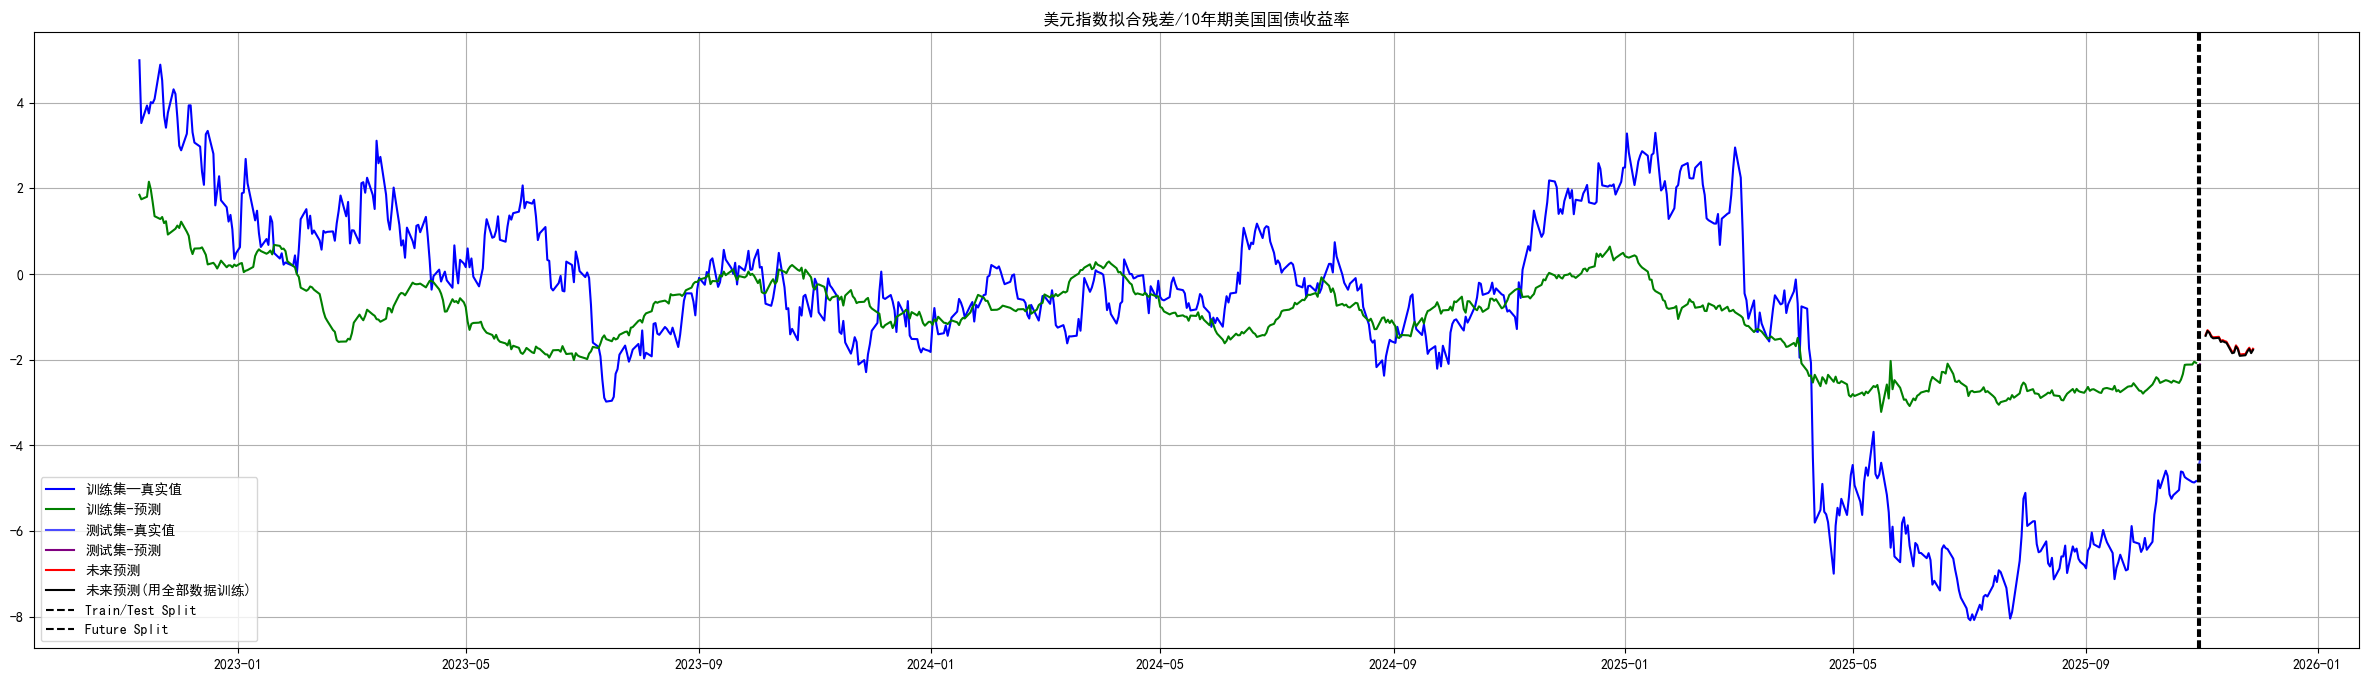

In [17]:
################################# 可视化 #################################
# 创建一个新的图形
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)


plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('美元指数拟合残差/10年期美国国债收益率')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
'''

#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)
'''

'\n\n#绘制因子重要性\nplot_xgb_feature_importance(model_all, X_train)\n'

---

In [19]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/美元指数拟合残差-10年期美国国债收益率_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/美元指数拟合残差-10年期美国国债收益率_月度数据.xlsx', index=False,float_format= '%.4f')

In [20]:
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,-1.653528
33,2025/10/31,-5.135291,-2.404609
32,2025/09/30,-6.451123,-2.684687
31,2025/08/31,-6.502443,-2.790656
30,2025/07/31,-7.275639,-2.801984
29,2025/06/30,-6.811986,-2.555179
28,2025/05/31,-5.335087,-2.762498
27,2025/04/30,-4.105468,-2.365377
26,2025/03/31,-0.646905,-1.398677
25,2025/02/28,1.835305,-0.771079


In [21]:
merged_df_daily

,Date,真实值,预测值
768,2025/11/28,NaN,-1.771937
767,2025/11/27,NaN,-1.846767
766,2025/11/26,NaN,-1.748146
765,2025/11/25,NaN,-1.808427
764,2025/11/24,NaN,-1.896395
...,...,...,...
4,2023/01/06,2.1180,NaN
3,2023/01/05,2.6861,NaN
2,2023/01/04,1.9023,NaN
1,2023/01/03,1.8837,NaN


In [22]:
merged_df_daily.head(30)

,Date,真实值,预测值
768,2025/11/28,NaN,-1.771937
767,2025/11/27,NaN,-1.846767
766,2025/11/26,NaN,-1.748146
765,2025/11/25,NaN,-1.808427
764,2025/11/24,NaN,-1.896395
763,2025/11/21,NaN,-1.910114
762,2025/11/20,NaN,-1.756371
761,2025/11/19,NaN,-1.692820
760,2025/11/18,NaN,-1.834907
759,2025/11/17,NaN,-1.848541


---

In [23]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美元指数拟合残差/10年期美国国债收益率"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [24]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美元指数拟合残差/10年期美国国债收益率"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
